In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import readdy

print(readdy.__version__)

v2.0.2-103


Set up a cubic periodic box and register one species `A` with diffusion constant $D=1$. The simulation adds 800 particles in the origin. We observe the particle positions at every timestep and run the simulation for a given amount of steps.

In [2]:
system = readdy.ReactionDiffusionSystem(
    box_size=[10, 10, 10], 
    periodic_boundary_conditions=[True, True, True],
    unit_system=None)
system.add_species("A", 1.0)

simulation = system.simulation(kernel="SingleCPU")

simulation.output_file = "out_msd.h5"
simulation.observe.particle_positions(stride=1)
init_pos = np.zeros((800, 3))
simulation.add_particles("A", init_pos)

if os.path.exists(simulation.output_file):
    os.remove(simulation.output_file)

simulation.run(n_steps=5000, timestep=1e-3)

  5%|▌         | 26/500 [00:00<00:01, 255.96it/s]

Configured kernel context with:
--------------------------------
 - kBT = 1
 - periodic b.c. = (true, true, true)
 - box size = (10, 10, 10)
 - particle types:
     *  particle type "A" with D=1

Configured simulation loop with:
--------------------------------
 - timeStep = 0.001
 - evaluateObservables = true
 - progressOutputStride = 100
 - context written to file = true
 - Performing actions:
   * Initialize neighbor list? true
   * Update neighbor list? true
   * Clear neighbor list? true
   * Integrate diffusion? true
   * Calculate forces? true
   * Handle reactions? true
   * Handle topology reactions? true



100%|██████████| 500/500 [00:01<00:00, 254.82it/s]


Load the trajectory containing the observables. Since there were no reactions in the system we can assume that the particle positions is of fixed shape `(T, N, 3)`, where `N` does not change over time. We may want to cast the positions into a numpy array.

In [3]:
traj = readdy.Trajectory(simulation.output_file)
times, positions = traj.read_observable_particle_positions()
times = np.array(times) * 1e-3

# convert to pure numpy array to make use of fancy operations
T = len(positions)
N = len(positions[0])
pos = np.zeros(shape=(T, N, 3))
for t in range(T):
    for n in range(N):
        pos[t, n, 0] = positions[t][n][0]
        pos[t, n, 1] = positions[t][n][1]
        pos[t, n, 2] = positions[t][n][2]

Wrap the trajectories back to account for periodic boundaries
1. find the box index of each point in time for each particle and each coordinate
2. wrap the trajectory back to absolute positions for each particle using the box indices

In [4]:
# step 1.
box_size = 10.
box_indices = np.zeros(shape=(T, N, 3), dtype=int)
for t in range(1, T):
    for n in range(N):
        for coord in [0, 1, 2]:
            delta = pos[t, n, coord] - pos[t-1, n, coord]
            if delta > 0.5 * box_size:
                box_indices[t, n, coord] = box_indices[t-1, n, coord] - 1
            elif delta < - 0.5 * box_size:
                box_indices[t, n, coord] = box_indices[t-1, n, coord] + 1
            else:
                box_indices[t, n, coord] = box_indices[t-1, n, coord]

# step 2.
absolute_pos = np.zeros_like(pos)
for t in range(T):
    for n in range(N):
        absolute_pos[t, n] = pos[t, n] + box_indices[t, n].astype(float) * box_size

Using the absolute positions we can calculate the displacement from the initial positions and obtain the quadratic variation (the mean squared displacement) and its standard deviation. Since the particles do not interact their trajectories are uncorrelated and we obtain the standard error of the mean from the same experiment.

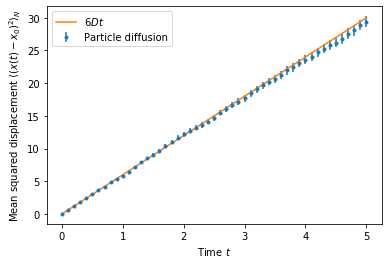

In [5]:
difference = absolute_pos - init_pos
# sum over coordinates, per particle per timestep
squared_displacements = np.sum(difference * difference, axis=2)
# squared_displacements has shape (T,N)
mean = np.mean(squared_displacements, axis=1)
std_dev = np.std(squared_displacements, axis=1)
std_err = np.std(squared_displacements, axis=1) / np.sqrt(squared_displacements.shape[1])

# plot
stride = 100
plt.errorbar(times[::stride], mean[::stride], yerr=std_err[::stride], fmt=".", label="Particle diffusion")
plt.plot(times[::stride], 6. * times[::stride], label=r"$6 D t$")
plt.legend(loc="best")
plt.xlabel(r"Time $t$")
plt.ylabel(r"Mean squared displacement $\langle (x(t) - x_0)^2 \rangle_N$")
plt.show()